In [263]:
# Description: New version of the whistle detection
#   1. python version
#   2. new SNR definition
#   3. modified narrow-band & long time duration filter 
#   4. use DBSCAN to deal with clustering


# Read through wave file and detect the following 
# features.
#   1. Whistle start fre
#   2. Whistle end fre
#   3. Whistle start time 
#   4. Whistle end time 
#   5. Whistle duration time 
#   6. Whistle total numbre count  
#   7. Whislte total duration 
######################################################

# basic package you definitly know
import numpy as np
import matplotlib.pyplot as plt
import math
import pandas as pd
import os.path
import time

# package for read wave file 
import soundfile as sf

# package for signal processing
import scipy.signal
from scipy.fftpack import fft

# package for image processing
import cv2

# package for clustering
from sklearn.cluster import DBSCAN

class ShaneWhistleDetector():
    def __init__(self, waf_file_name):
        self.data, self.fs = sf.read(waf_file_name)
        if(len(self.data.shape)==2):
            self.data = self.data[:,0]
        print("Successfully get {} data:".format(waf_file_name))
        print("Total duration: {} (Sec)".format(len(self.data)/self.fs))
        print("Sampling rate: {} (S/s)".format(self.fs))       
    # Set all needed parameters    
    def onStartUp(self):
        # Parameters for removeClick function
        self.threshold_click_removal = 5
        self.power_click_removal = 6

        # Parameters for computeSTFT function
        self.fft_number = 1024
        self.overlab = 0.5
        self.window_type = "hann"
        self.sensitivity = 211
        
        # Parameters for bandPassWithSNRFilter function
        self.start_fre = 3000
        self.end_fre = 12000

        # Parameters for whistleFeatureFilter function
        self.frequency_width = 300
        self.defined_SNR = 12
        self.time_duration = 0.02

        # Parameters for DBSCANCluster function
        self.eps = 20
        self.min_samples = 5

        # Parameters for detectWhistle function
        self.whistle_detector_frame = 2
        self.time_start_index = 0

        # Count numbers for whistle detector features
        self.whistle_count = 0
        self.whistle_duration = 0

    # Print out all whislte detector parameters
    def printSetting(self):
        hop_size = math.ceil(self.fft_number*(1-self.overlab))
        dt = hop_size/self.fs
        df = self.fs/self.fft_number
        col_size = math.ceil(self.time_duration/dt)
        print("######################################################")
        print("#         Parameters for removeClick function        #")
        print("######################################################")
        print("     1. Threshold: \t{}".format(self.threshold_click_removal))
        print("     2. Power: \t\t{}".format(self.power_click_removal))
        print()
        print("------------------------------------------------------")
        print("######################################################")
        print("#         Parameters for computeSTFT function        #")
        print("######################################################")
        print("     1. FFT Number: \t\t{}".format(self.fft_number))
        print("     2. Overlab: \t\t{}".format(self.overlab))
        print("     3. Window Type: \t\t{}".format(self.window_type))
        print("     4. Hydrophone Sensitivity: {}".format(self.sensitivity))
        print("     delta t: \t\t{}".format(dt))
        print("     delta f: \t\t{}".format(df))
        print()
        print("------------------------------------------------------")
        print("######################################################")
        print("#    Parameters for bandPassWithSNRFilter function   #")
        print("######################################################")
        print("     1. Start Frequency: \t{} Hz".format(self.start_fre))
        print("     2. End Frequency: \t\t{} Hz".format(self.end_fre))
        print()
        print("------------------------------------------------------")
        print("######################################################")
        print("#    Parameters for whistleFeatureFilter function    #")
        print("######################################################")
        print("     1. Frequency Width: \t{} Hz".format(self.frequency_width))
        print("     2. self-defined SNR: \t{} dB".format(self.defined_SNR))
        print("     3. Time duration: \t\t{} Sec".format(self.time_duration))
        print("     col rule: \t\t{} out of {} ".format(int(col_size*0.9),col_size))
        print()
        print("------------------------------------------------------")
        print("######################################################")
        print("#        Parameters for DBSCANCluster function       #")
        print("######################################################")
        print("     1. Eps range: \t{}".format(self.eps))
        print("     2. Minimum samples: {}".format(self.min_samples))
        print()
        print("------------------------------------------------------")
        print("######################################################")
        print("#        Parameters for detectWhistle function       #")
        print("######################################################")
        print("     1. Whistle Detector Window: {} Sec".format(self.whistle_detector_frame))
        print()
        print("------------------------------------------------------")


    #################################################
    # first step, click removal through time series #
    #################################################
    # Parameters:
    #   1. threshold
    #   2. power
    def removeClick(self,x):
        x = np.array(x*100)
        m = np.mean(x)
        SD = np.std(x)
        w = 1.0/(1+((x-m)/self.threshold_click_removal*SD)**self.power_click_removal)
        return w*x/100   

    #############################
    # Second step, STFT process #
    #############################
    # Parameters:
    #   1. fft_number
    #   2. window_type
    #   3. overlap ratio
    #   4. hydrophone sensitivity
    def computeSTFT(self):
        PSD_clickRemoval = []
        hop_size = math.ceil(self.fft_number*(1-self.overlab))
        window = scipy.signal.get_window(self.window_type, self.fft_number, fftbins=True)
        fft_half_number = math.ceil((self.fft_number+1)/2)

        total_stft_frame = (self.whistle_detector_frame*self.fs-self.fft_number)//hop_size+1
        self.total_sample_count = (total_stft_frame-1)*hop_size+self.fft_number

        sample_time_series = self.data[self.time_start_index:self.time_start_index+self.total_sample_count]
        
        
        end_index = self.fft_number
        for i in range(total_stft_frame):
            weighted_data = self.removeClick(sample_time_series[end_index-self.fft_number:end_index])
            windowed_data = window*weighted_data
            z = fft(windowed_data)[:fft_half_number]/self.fft_number*2
            psd = 20*np.log10(abs(z)**2) + self.sensitivity
            PSD_clickRemoval.append(psd)
            end_index += hop_size
        PSD_clickRemoval = np.array(PSD_clickRemoval)
        return PSD_clickRemoval

    #############################
    # Third step, image bluring #
    #############################
    # applying median bluring



    #############################################
    # Fourth step, band passing & SNR threshold #
    #############################################
    # Parameters:
    #   1. start freq
    #   2. end freq
    #   3. SNR threshold


    ##################################
    # Fifth step, long time duration #
    ##################################
    # Parameters:
    #   1. frequency width
    #   2. time duration
    def whistleFeatureFilter(self, median_blur):
        hop_size = math.ceil(self.fft_number*(1-self.overlab))
        dt = hop_size/self.fs
        df = self.fs/self.fft_number
        start_index = math.floor((self.start_fre)/df)
        end_index = math.ceil((self.end_fre)/df)
        width_size = math.ceil(self.frequency_width/2/df)
        
        ## high PSD level and high SNR reference to narrow band level
        SNR = []
        for row in median_blur:
            p2 = row[start_index-width_size:end_index-width_size]
            p1 = row[start_index:end_index]
            p3 = row[start_index+width_size:end_index+width_size]
            snr = 2*p1-(p2+p3)
            SNR.append(snr)
        SNR = np.array(SNR)

        SNR_median_blur = cv2.medianBlur(SNR.astype(np.float32),3)
#         SNR_filter = (SNR>self.defined_SNR)
        SNR_filter = (SNR_median_blur>self.defined_SNR)
        # Long time duration
        col_size = math.ceil(self.time_duration/dt)
        image_row = SNR_filter.T.shape[0]
        image_col = SNR_filter.T.shape[1]
        padding = np.zeros((image_row, image_col+col_size-1))
        padding[:,col_size//2:col_size//2+image_col] = SNR_filter.T
        detection = np.zeros((image_row, image_col))
        for i in range(col_size):
            detection += padding[:,i:i+image_col]
        return detection==col_size

    def DBSCANCluster(self, detection, filename):
        hop_size = math.ceil(self.fft_number*(1-self.overlab))
        df = self.fs/self.fft_number
        dt = hop_size/self.fs

        (x,y) = np.nonzero(detection.T)
        if len(x):
            point = np.array([x,y]).T
            clustering=DBSCAN(eps=self.eps,min_samples=self.min_samples).fit(point)

            point_without_outlier = point[clustering.labels_!=-1]
            new_label = clustering.labels_[clustering.labels_!=-1]
            point_x = point_without_outlier.T[0]*dt+self.time_start_index/self.fs
            self.time_start_index += self.total_sample_count
            point_y = (point_without_outlier.T[1]*df+self.start_fre)/1000

            length = len(set(new_label))
            col = ['Start Time','End Time','Start Freq','End Freq','Duration']
            feature = []
            for i in range(length):
                cluster_x = point_x[new_label==i]
                cluster_y = point_y[new_label==i]
                if(cluster_x[-1]-cluster_x[0]>0.05):
                    feature.append([cluster_x[0], cluster_x[-1], cluster_y[0], cluster_y[-1], cluster_x[-1]-cluster_x[0]])
                    self.whistle_duration += cluster_x[-1]-cluster_x[0]
                    self.whistle_count += 1
            df = pd.DataFrame(feature, columns=col)
            if os.path.isfile(filename):
                df.to_csv(filename, mode='a', header=False, index=False)
            else:
                df.to_csv(filename, mode='w', header=True, index=False)
        else:
            self.time_start_index += self.total_sample_count  
    
    def detectWhistle(self, sec=0, csv_file='whislte_detection_outcome.csv'):
        wave_file_long = len(self.data)/self.fs
        if(sec>wave_file_long):
            print("Input parameter sec is too large, the max number is {}.".format(wave_file_long))
            return 
        elif(sec!=0):
            cut = wave_file_long-sec
            print("Detecting whistle in first {} seconds of the file ...\n".format(sec))
        else:
            print("Detecting whistle in full file ... \n")
            cut = 0
        self.printSetting()

        self.stft_with_click_removal_time = []
        self.median_blur_time = []
        self.high_SNR_time = []
        self.detection_time = []
        self.clustering_time = []
        
        start = time.time()
        while(self.time_start_index+self.whistle_detector_frame*self.fs<=len(self.data)-cut*self.fs):
            t_1 = time.time()
            PSD_clickRemoval = self.computeSTFT()
            t_2 = time.time()
            self.stft_with_click_removal_time.append(t_2-t_1)
            median_blur = cv2.medianBlur(PSD_clickRemoval.astype(np.float32),3)
            t_3 = time.time()
            self.median_blur_time.append(t_3-t_2)
            detection = self.whistleFeatureFilter(median_blur)
            t_5 = time.time()
            self.detection_time.append(t_5-t_3)
            self.DBSCANCluster(detection, csv_file)
            t_6 = time.time()
            self.clustering_time.append(t_6-t_5)
        end = time.time()
        print("elapsed time: {} Sec".format(end-start))

In [264]:
file_name = '/home/yong/Downloads/SM305955_0+1_20200831_040000.wav'
d = ShaneWhistleDetector(file_name)

Successfully get /home/yong/Downloads/SM305955_0+1_20200831_040000.wav data:
Total duration: 3595.0 (Sec)
Sampling rate: 96000 (S/s)


In [267]:
import os
for j in range(1,2):
    for i in range(1,2):
        d.onStartUp()
        d.defined_SNR = i*12
        d.time_duration = j*0.02
        path = "/home/yong/new_python_work/PAM/algorithm_test/detect_overlab50_" + str(round(j*0.02,3))
        try:
            os.mkdir(path)
        except OSError:
            print("Creation of the directory failed")
        file = path + "/whistle_test_SNR_" + str(i*12) + ".csv"
        d.detectWhistle(sec=10*60, csv_file=file)

Creation of the directory failed
Detecting whistle in first 600 seconds of the file ...

######################################################
#         Parameters for removeClick function        #
######################################################
     1. Threshold: 	5
     2. Power: 		6

------------------------------------------------------
######################################################
#         Parameters for computeSTFT function        #
######################################################
     1. FFT Number: 		1024
     2. Overlab: 		0.5
     3. Window Type: 		hann
     4. Hydrophone Sensitivity: 211
     delta t: 		0.005333333333333333
     delta f: 		93.75

------------------------------------------------------
######################################################
#    Parameters for bandPassWithSNRFilter function   #
######################################################
     1. Start Frequency: 	3000 Hz
     2. End Frequency: 		12000 Hz

---------------------

In [241]:
# d.detectWhistle(csv_file="a_one_hour_data.csv")
d.onStartUp()
d.printSetting()

######################################################
#         Parameters for removeClick function        #
######################################################
     1. Threshold: 	5
     2. Power: 		6

------------------------------------------------------
######################################################
#         Parameters for computeSTFT function        #
######################################################
     1. FFT Number: 		1024
     2. Overlab: 		0.5
     3. Window Type: 		hann
     4. Hydrophone Sensitivity: 211
     delta t: 		0.005333333333333333
     delta f: 		93.75

------------------------------------------------------
######################################################
#    Parameters for bandPassWithSNRFilter function   #
######################################################
     1. Start Frequency: 	3000 Hz
     2. End Frequency: 		12000 Hz

------------------------------------------------------
######################################################


In [242]:
# d.detectWhistle()

In [243]:
d.whistle_detector_frame = 5
start_time = 16
d.time_start_index = start_time*d.fs
d.defined_SNR = 10
d.time_duration = 0.01
d.frequency_width = 300
PSD_clickRemoval = d.computeSTFT()
# PSD = d.computeSTFT_()

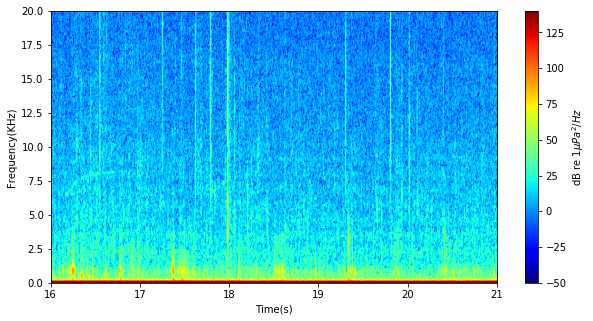

In [244]:
fig, ax = plt.subplots(figsize=(10,5))
im = ax.imshow(PSD_clickRemoval.T, cmap='jet',  vmin=-50, vmax=140, origin='lower', aspect='auto', 
               interpolation='hanning', extent=(start_time, start_time+5, 0, d.fs//2/1000))
ax.set_ylim([0,20])
ax.set_xlabel("Time(s)")
ax.set_ylabel("Frequency(KHz)")
c_bar = fig.colorbar(im)
c_bar.set_label("dB re 1" + r'$\mu Pa^{2}/Hz$')
plt.show()

In [245]:
median_blur = cv2.medianBlur(PSD_clickRemoval.astype(np.float32),3)
median_blur.shape

(936, 513)

In [246]:
detection = d.whistleFeatureFilter(median_blur)
detection.shape

(96, 936)

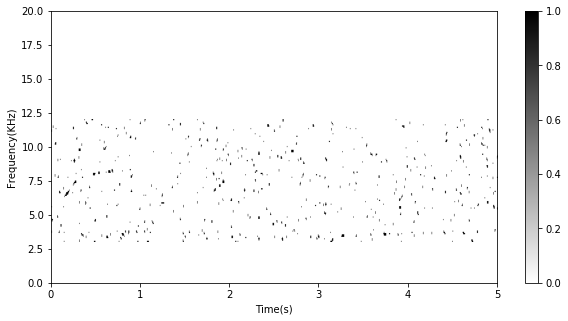

In [247]:
half_size = math.ceil((d.fft_number+1)/2)
f = np.arange(half_size)*d.fs/d.fft_number
df = d.fs/d.fft_number


start_index = math.floor((d.start_fre)/df)
end_index = math.ceil((d.end_fre)/df)


fig, ax = plt.subplots(figsize=(10,5))
im = ax.imshow(detection.astype(np.int8), cmap='binary',  origin='lower', aspect='auto',
               interpolation='hanning', extent=(0, 5, f[start_index]/1000, f[end_index]/1000))
ax.set_ylim([0,20])
ax.set_xlabel("Time(s)")
ax.set_ylabel("Frequency(KHz)")
c_bar = fig.colorbar(im)
plt.show()

row_size: 7
col_size: 19


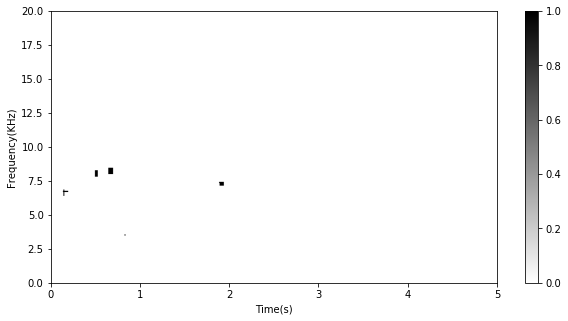

In [262]:
time_duration = 0.1
freq_width = 600
hop_size = math.ceil(d.fft_number*(1-d.overlab))
dt = hop_size/d.fs
df = d.fs/d.fft_number

row_size = math.ceil(freq_width/df)
col_size = math.ceil(time_duration/dt)
print("row_size: {}".format(row_size))
print("col_size: {}".format(col_size))
image_row = detection.shape[0]
image_col = detection.shape[1]

padding = np.zeros((image_row+row_size-1, image_col))
padding[row_size//2:row_size//2+image_row,:] = detection.astype(np.int8)
row_c = np.zeros((image_row, image_col))
for i in range(row_size):
     row_c += padding[i:i+image_row,:]
row_c = row_c>=2
padding = np.zeros((image_row, image_col+col_size-1))
padding[:,col_size//2:col_size//2+image_col] = row_c.astype(np.int8)
col_c = np.zeros((image_row, image_col))
for i in range(col_size):
    col_c += padding[:,i:i+image_col]
dd = col_c>=(col_size*0.35)
# dd = col_c
half_size = math.ceil((d.fft_number+1)/2)
f = np.arange(half_size)*d.fs/d.fft_number
df = d.fs/d.fft_number


start_index = math.floor((d.start_fre)/df)
end_index = math.ceil((d.end_fre)/df)


fig, ax = plt.subplots(figsize=(10,5))
im = ax.imshow(dd.astype(np.int8), cmap='binary',  origin='lower', aspect='auto',
               interpolation='hanning', extent=(0, 5, f[start_index]/1000, f[end_index]/1000))
ax.set_ylim([0,20])
ax.set_xlabel("Time(s)")
ax.set_ylabel("Frequency(KHz)")
c_bar = fig.colorbar(im)
plt.show()

In [251]:
(x,y) = np.nonzero(detection.T)
c = np.array([x/10,y]).T
clustering=DBSCAN(eps=20,min_samples=10).fit(c)

In [164]:
point = c[clustering.labels_!=-1]
new_label = clustering.labels_[clustering.labels_!=-1]

In [165]:
hop_size = math.ceil(d.fft_number*(1-d.overlab))
dt = hop_size/d.fs

point_x = point.T[0]*dt*10 + start_time
point_y = point.T[1]*df/1000+2

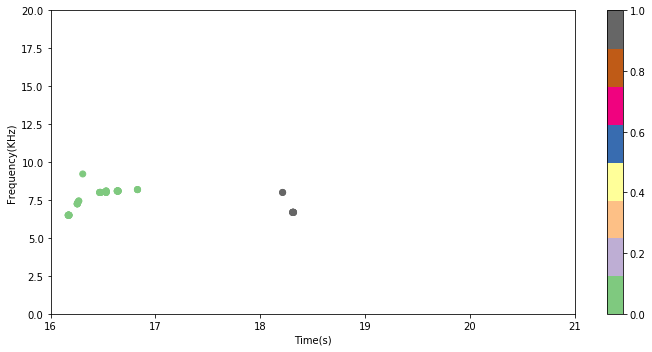

In [166]:
fig, ax = plt.subplots(figsize=(10,5))
im = ax.scatter(point_x,point_y, c=new_label, cmap="Accent")

ax.set_ylim([0,20])
ax.set_xlim([start_time,start_time+5])
ax.set_xlabel("Time(s)")
ax.set_ylabel("Frequency(KHz)")
c_bar = fig.colorbar(im)
plt.tight_layout()